In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from causadb import CausaDB
import os
import numpy as np

client = CausaDB(token=os.getenv("CAUSADB_TOKEN"))

In [3]:
from causadb.examples.heating import get_heating_dataset, set_heating
data = get_heating_dataset()

client \
  .add_data("quickstart-heating-data") \
  .from_pandas(data)

data.head()

,day,outdoor_temp,heating,indoor_temp,energy
0,0,13.91,57.0,19.86,679.0
1,1,13.21,61.0,20.53,709.0
2,2,14.30,56.0,18.77,683.0
3,3,14.96,54.0,19.85,675.0
4,4,13.79,60.0,20.36,711.0


In [4]:
# Define a causal model (can also be done in the UI)
model = client.create_model("quickstart-heating-model")
model.set_nodes(["outdoor_temp", "heating", "indoor_temp", "energy"])
model.set_edges([
    ("outdoor_temp", "heating"),
    ("outdoor_temp", "indoor_temp"),
    ("heating", "indoor_temp"),
    ("heating", "energy"),
    ("indoor_temp", "energy")
])

In [5]:
model.train("quickstart-heating-data")

In [6]:
model.simulate_actions(actions={
  "heating": [46, 54],
  "outdoor_temp": [12, 14]
})["median"]

,day,outdoor_temp,heating,indoor_temp,energy
0,0.0,12.0,46.0,15.95563,598.974251
1,0.0,14.0,54.0,18.48869,669.494182


In [7]:
model.simulate_actions(actions={
  "heating": 46,
  "outdoor_temp": 12
})["lower"]

,day,outdoor_temp,heating,indoor_temp,energy
0,0.0,12.0,46.0,15.417394,594.684237


In [8]:
best_actions = model.find_best_actions(
    targets={"indoor_temp": 19},
    actionable=["heating"],
    fixed={"outdoor_temp": 16}
)

achieved_indoor_temp = set_heating(best_actions["heating"].values, np.array([16]), noise=False)[0]

print(f"Best heating setting: {best_actions['heating'].values[0]:.1f}")
print(f"Indoor temperature achieved: {achieved_indoor_temp[0]:.1f}°C")

Best heating setting: 54.6
Indoor temperature achieved: 19.1°C


In [9]:
model.causal_effects({"heating": [50, 55]}, fixed={"outdoor_temp": 15})

,median,lower,upper
day,0.000000,0.000000,0.000000
outdoor_temp,0.000000,0.000000,0.000000
heating,5.000000,5.000000,5.000000
indoor_temp,1.341441,1.180138,1.508210
energy,43.019980,40.734694,45.161236


In [10]:
causal_attributions = model.causal_attributions("energy")
causal_attributions

,energy
outdoor_temp,-25.683866
heating,8.385283
indoor_temp,1.632694


<Axes: title={'center': 'Causal attribution of energy'}, xlabel='Causal attribution', ylabel='Node'>

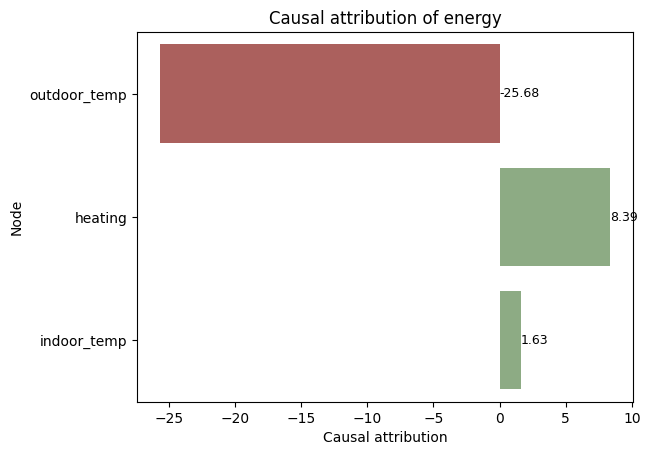

In [11]:
from causadb.plotting import plot_causal_attributions, plot_causal_graph

plot_causal_attributions(model, "energy", normalise=False)

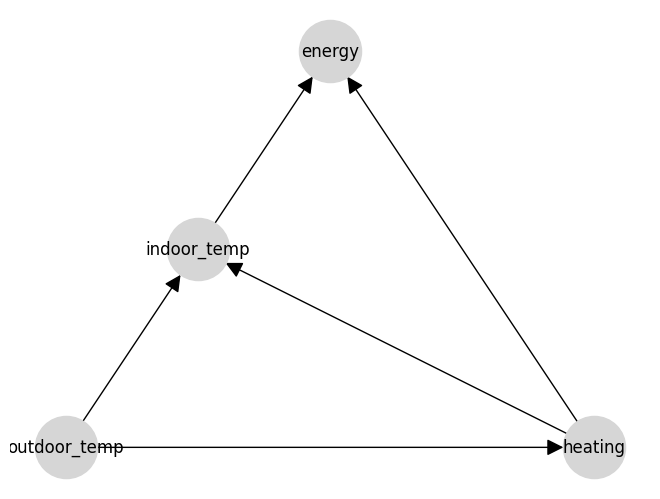

In [24]:
plot_causal_graph(model)